This notebooks porduces figures 3 and 4 from the publication.

To produce figure 4, data of products must be pre-calculated, which can be done with the scripts within the folders of `data/fig_4_data/`. Just activate the environment in the terminal and run `python make_diagram.py`.

Plots will be saved to `../results/`

In [1]:
import re
import os

import numpy as np
from IPython.display import display, Image
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import cantera as ct

import simulation as ctt

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper',font_scale=1.5)

%matplotlib inline

In [31]:
directory = '../data/mechanism/'
directory_fig_4_data = '../data/fig_4_data/'
image_path = '../results/'

In [3]:
butanol_vars = {
    'input_path': directory,
    "conversion_species": ['gR', 'gRO2'],
    "starting_alkyl_radical": 'gR',
    # 8 cycles
    "species_to_plot": ['OOCC(CO)C', # hydroperoxy
                       ['[O]CC(CO)C','galdol'],  # NO reaction
                       'OOCC(C=O)C', # isom
                       ['galdoxy','O=CC(C)C=O'], # water formation
                       ['CC=C','propene3ol'], # r decomp
                        'NO2OCC(CO)C', # nirate formation
                       'galkene', # HO2 alkene
                       ['disub_c4ether','disub_epoxy','monosub_c4ether'], # cyclic ether
                       ['OOCC(C(O[O])O)C','O=CC(C)C(OO)O','OOCC(CO)CO[O]','OCC(O[O])(COO)C','O=CC(CO)COO','OCC(OO)(C=O)C'],# chain oxidation
                      ],
    "in_legend": ['hydroperoxy', 'alkoxy','isom','water loss','R decomp','nitrate','epoxy','alkene'],
    'image_path': overall_image_path,
    'reactions_to_remove': None,
#    """products not accounted for in the above scheme:
#       
#       OOCC(C=O)C - from the H-transfer from hydroxyl group followed by disproportionation by O2
#       CC=CO - from the double \beta scission pathway with semi-high barrier
#       """
}
butanol_vars['cantera_input_file'] =  os.path.join(butanol_vars['input_path'],'gamma_i_butanol.cti')
propane_vars = {
    'input_path': directory,
    'conversion_species': ['npropyl','npropyloo'],
    'starting_alkyl_radical': 'npropyl',
    'species_to_plot': ['npropylooh',
                       ['npropyloxy','propanal','CH3CH2OO','CH3CH2OOH'], #the c2 comes from breaking of npropyloxy
                       ['prod_1','CO'], # 1 CO produced by the khp cycle
                       'C3H6',
                       'C2H4',
                       'npropylONO2',
                       'propoxide'],
    'in_legend': ['hydroperoxy', 'alkoxy','isom','propene', 'R decomp','nitrate','epoxy'],
    'image_path': overall_image_path,
    'reactions_to_remove': ['CH3CH2OO + NO <=> NO2 + ethoxy',
                       'C2H4 + H (+M) <=> C2H5 (+M)',
                       '2 C2H4 <=> C2H3 + C2H5',
                       'C2H5 + CH3 <=> C2H4 + CH4',
                       'C2H5 + H <=> C2H4 + H2',
                       'C2H5 + O2 <=> C2H4 + HO2',
                       'C2H5 + O2 <=> C2H4 + HO2',
                       'C2H5 + allyl <=> C2H4 + C3H6',
                       'CH3CH2OO <=> C2H4 + HO2',
                       'CH2CH2OOH <=> CH3CH2OO',
                       'C2H5 + O2 <=> CH2CH2OOH',
                       'npropyl <=> C3H6 + H',
                       'OH + propanal <=> H2O + propionyl',
                       'HO2 + propanal <=> H2O2 + propionyl',
                      ]
}

propane_vars['cantera_input_file'] =  os.path.join(propane_vars['input_path'],'merchant-full_w_NO.cti')


In [4]:
cb = sns.color_palette('colorblind')
colorblind_custom = [cb[2], cb[4], cb[8], cb[3], cb[9], cb[1], cb[6], cb[0], cb[7]]

# methods

In [5]:
def get_heatmap_data(df, plotted_elements, temperatures=np.linspace(250,1250,25), pressures = np.logspace(3,7,15), colors=None):
    heatmap = pd.DataFrame(index=pressures, columns = temperatures)
    if colors is None:
        colors = colorblind_custom[:len(plotted_elements)]
    else:
        colors = colors[:len(plotted_elements)]
    for index in df.index:
        plotted_element_values = []
        for e in plotted_elements:
            if isinstance(e, list):
                plotted_element_values.append(df.loc[index,e].sum())
            else: plotted_element_values.append(df.loc[index,e])
        if sum(plotted_element_values) > 1:
            print('found plotted element values greater than one')
            print(zip(in_legend,plotted_element_values))
        plotted_element_values = np.array(plotted_element_values) / sum(plotted_element_values)
        try:
            heatmap.loc[df.loc[index,'pres (Pa)'], df.loc[index,'temp (K)']]=\
                np.dot(plotted_element_values,colors)
            if any(heatmap.loc[df.loc[index,'pres (Pa)'], df.loc[index,'temp (K)']] > 1):
                print(df.loc[index,:])
                print(plotted_element_values)
                print(heatmap.loc[df.loc[index,'pres (Pa)'], df.loc[index,'temp (K)']])
                print(colors)
        except ValueError:
            print(len(colors))
            print(len(plotted_elements))
            print(len(plotted_element_values))
            print(np.dot(plotted_element_values,colors))
            print(plotted_element_values[0])
            print('unable to set the color in the heatmap. Did you put the proper temperature and pressure ranges in?')
            raise
    return heatmap

In [6]:
def get_heatmap_data_T_NO(df, plotted_elements, temperatures=np.linspace(250,1250,25), NO_fracs = np.logspace(-12,-4,15), colors=None):
    heatmap = pd.DataFrame(index=NO_fracs, columns = temperatures)
    if colors is None:
        colors = colorblind_custom[:len(plotted_elements)]
    else:
        colors = colors[:len(plotted_elements)]
    for index in df.index:
        plotted_element_values = []
        for e in plotted_elements:
            if isinstance(e, list):
                plotted_element_values.append(df.loc[index,e].sum())
            else: plotted_element_values.append(df.loc[index,e])
        plotted_element_values = np.array(plotted_element_values) / sum(plotted_element_values)
        try:
            if sum(plotted_element_values) < 0.85:
                print(df.loc[index,:].sort_values())
                raise Exception('could not find {0} of the products at T={1} and NO={2}'.format(1-sum(plotted_element_values), df.loc[index,'temp (K)'],df.loc[index,'NO (fraction)']))
            heatmap.loc[df.loc[index,'NO (fraction)'], df.loc[index,'temp (K)']]=\
                np.dot(plotted_element_values,colors)
        except ValueError:
            print('unable to set the color in the heatmap. Did you put the proper temperature and pressure ranges in?')
            raise
    return heatmap

In [7]:
def get_heatmap_graph(heatmap_data, legend_labels = [],num_xticks = 5, colors = None, pressure_scale='log', num_yticks = 6, ax=None, T_range = None):
    if colors is None:
        colors = colorblind_custom[:len(legend_labels)]
    else:
        colors = colors[:len(legend_labels)]
    nrows = len(heatmap_data.index)
    ncols = len(heatmap_data.columns)
    
    if not ax:
        ax = plt.subplot()
    for i_num, pressures in enumerate(heatmap_data.index):
        for c_num, temperatures in enumerate(heatmap_data.columns):
            rec = Rectangle((float(c_num)/ncols,float(i_num)/nrows), 1./ncols, 1./nrows,facecolor=heatmap_data.loc[pressures,temperatures],
                           linewidth=0,rasterized=True)
            ax.add_patch(rec)

    ax.set_xlabel('Temperature (K)')
    if T_range:
        tmin = T_range[0]
        tmax = T_range[1]
    else:
        tmin = int(np.round(np.min(heatmap_data.columns.values)))
        tmax = int(np.round(np.max(heatmap_data.columns.values)))
    xticks_minor = np.linspace(0,1,num_xticks * 5 - 4)
    ax.set_xticks(xticks_minor,minor=True)
    xticks = np.linspace(0,1,num_xticks)
    ax.set_xticks(xticks)
    ax.set_xticklabels([ int(tmin + (tmax-tmin)*i) for i in xticks])
    
    ax.set_ylabel('Pressure (bar)')
    pmin = np.min(heatmap_data.index.values)
    pmax = np.max(heatmap_data.index.values)
    if pressure_scale == 'log':
        if int(np.round(np.log10(pmin))) == 4 and int(np.round(np.log10(pmax))) == 6:
            ax.set_yticks([0,.5,1])
            ax.set_yticklabels([0.1, 1, 10])
        elif int(np.round(np.log10(pmin))) == 3 and int(np.round(np.log10(pmax))) == 7:
            yticks_minor_one_order_magnitude = np.log10(range(10)[1:])
            oom_span = 4
            yticks_minor = np.concatenate([(yticks_minor_one_order_magnitude + i)/4 for i in range(oom_span)])
            ax.set_yticks(yticks_minor, minor=True)
            ax.set_yticks([0,.25,.5,.75,1])
            ax.set_yticklabels([0.01,0.1, 1, 10, 100])
        else:
            raise Exception('Have not implemented proper y axis labels for the pressure range 10**{0}-10**{1}.'.format(pmin,pmax))
    elif pressure_scale == 'linear':
        # make like temperatures
        yticks = np.linspace(0,1,num_yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels([ int(pmin + (pmax-pmin)*i) / 1.0e5 for i in yticks])
    else:
        raise Exception('Only linear and log attributes accepted for pressure_scale')
    legend_icons = [Rectangle((0,0), 1, 1,facecolor=color) for color in colors]
    kwargs = {'bbox_to_anchor':(0.0, -.2), 'loc':2, 'borderaxespad':0.}
    ax.legend(legend_icons,legend_labels,**kwargs)

    return ax

In [8]:
def get_heatmap_graph_T_NO(heatmap_data, legend_labels = [],num_xticks = 5, colors = None, NO_scale='log', num_yticks = 6, ax=None, T_range=None):
    if colors is None:
        colors = colorblind_custom[:len(legend_labels)]
    else:
        colors = colors[:len(legend_labels)]
    nrows = len(heatmap_data.index)
    ncols = len(heatmap_data.columns)
    if not ax:
        ax = plt.subplot()
    for i_num, pressures in enumerate(heatmap_data.index):
        for c_num, temperatures in enumerate(heatmap_data.columns):
            rec = Rectangle((float(c_num)/ncols,float(i_num)/nrows), 1./ncols, 1./nrows,facecolor=heatmap_data.loc[pressures,temperatures],
                            linewidth=0,rasterized=True)
            ax.add_patch(rec)

    ax.set_xlabel('Temperature (K)')
    if T_range:
        tmin = T_range[0]
        tmax = T_range[1]
    else:
        tmin = int(np.round(np.min(heatmap_data.columns.values)))
        tmax = int(np.round(np.max(heatmap_data.columns.values)))
    xticks = np.linspace(0,1,num_xticks)
    xticks_minor = np.linspace(0,1,num_xticks * 5 - 4)
    ax.set_xticks(xticks_minor,minor=True)
    ax.set_xticks(xticks)
    ax.set_xticklabels([ int(tmin + (tmax-tmin)*i) for i in xticks])
    
    ax.set_ylabel('NO',rotation='horizontal')
    pmin = np.min(heatmap_data.index.values)
    pmax = np.max(heatmap_data.index.values)
    if NO_scale == 'log':
        if int(np.round(np.log10(pmin))) == -12 and int(np.round(np.log10(pmax))) == -4:
            yticks_minor = np.linspace(0,1,9)
            ax.set_yticks(yticks_minor,minor=True)
            ax.set_yticks([0,3./8,6./8,1])
            ax.set_yticklabels(['1 ppt', '1 ppb','1 ppm', '100 ppm'])
        elif int(np.round(np.log10(pmin))) == 3 and int(np.round(np.log10(pmax))) == 7:
            ax.set_yticks([0,.25,.5,.75,1])
            ax.set_yticklabels([0.01,0.1, 1, 10, 100])
        else:
            raise Exception('Have not implemented proper y axis labels for the NO range 10**{0}-10**{1}.'.format(pmin,pmax))
    elif NO_scale == 'linear':
        # make like temperatures
        yticks = np.linspace(0,1,num_yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels([ int(pmin + (pmax-pmin)*i) / 1.0e5 for i in yticks])
    else:
        raise Exception('Only linear and log attributes accepted for NO_scale')
    legend_icons = [Rectangle((0,0), 1, 1,facecolor=color) for color in colors]
    kwargs = {'bbox_to_anchor':(0.0, -.2), 'loc':2, 'borderaxespad':0.}
    ax.legend(legend_icons,legend_labels,**kwargs)

    return ax

# figure 4

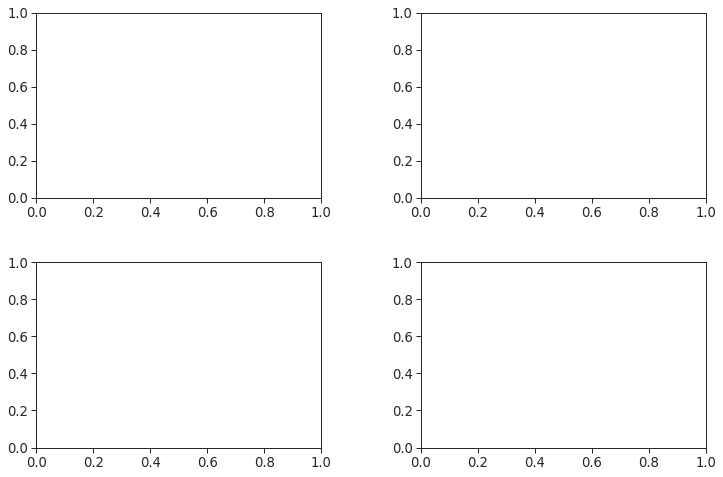

In [9]:
f, axes = plt.subplots(nrows=2,ncols=2,figsize = [12,8],gridspec_kw={'wspace':.35,'hspace':0.35})

In [10]:
annotate = False

In [11]:
shorter_range = False # only show 250-750
if shorter_range:
    num_xticks = 6
    T_range = (250,750)
else:
    num_xticks = 5
    T_range = None

In [12]:
import pandas as pd

In [13]:
colorblind_custom_butanol= [colorblind_custom[x] for x in [0, 1, 2, 7,  4,5,6, 3,8,]]

In [16]:
axis_func = get_heatmap_graph

# for butanol_1ppb
file_name = 'butanol_1ppb/run_data.pic'
df = pd.read_pickle(os.path.join(directory_fig_4_data, file_name))
if shorter_range:
    df = df[df['temp (K)'] < 750]
temperatures = list(set(df['temp (K)']))
temperatures.sort()
pressures = list(set(df['pres (Pa)']))
pressures.sort()
species_to_plot = butanol_vars['species_to_plot']
heatmap_data = get_heatmap_data(df,species_to_plot, temperatures=temperatures, pressures = pressures, colors=colorblind_custom_butanol)
ax = axes[0][1]
axis_func(heatmap_data,num_xticks=num_xticks,ax=ax, T_range=T_range, colors=colorblind_custom_butanol)
if annotate:
    ax.annotate('alkoxy',(0.05,.8), (.1,0.9), arrowprops={'arrowstyle':'-'})
    ax.annotate('isom',(0.125,.7), (.175,0.8), arrowprops={'arrowstyle':'-'})
    ax.annotate('water loss', (0.25,.6))
    ax.annotate('R decomp', (0.65,.5))
    #ax.annotate('C',(0.90,0.85),color = 'w', fontsize = 30)
ax.annotate('(c)',(0.0,1.1), fontsize = 12)
ax.legend([],frameon=False,loc='right')

# for propane_1ppb
file_name = 'propane_1ppb/run_data.pic'
df = pd.read_pickle(os.path.join(directory_fig_4_data, file_name))
if shorter_range:
    df = df[df['temp (K)'] < 750]
species_to_plot = propane_vars['species_to_plot']
heatmap_data = get_heatmap_data(df,species_to_plot, temperatures=temperatures, pressures = pressures, colors=colorblind_custom)
ax = axes[0][0]
axis_func(heatmap_data,num_xticks=num_xticks,ax=ax, T_range=T_range, colors=colorblind_custom)
if annotate:
    ax.annotate('alkoxy',(0.05,.85))
    ax.annotate('isom',(0.27,.65), )
    ax.annotate('alkene', (0.55,.75),(0.6,0.73),arrowprops={'arrowstyle':'-'})
    ax.annotate('R decomp', (0.65,.2))
    #ax.annotate('A',(0.90,0.85),color = 'w', fontsize = 30)
ax.annotate('(a)',(0.0,1.1), fontsize = 12)
ax.legend([],frameon=False, loc='right')

# constant pressure
axis_func = get_heatmap_graph_T_NO

# for butanol_1bar
file_name = 'butanol_1bar/run_data.pic'
df = pd.read_pickle(os.path.join(directory_fig_4_data, file_name))
if shorter_range:
    df = df[df['temp (K)'] < 750]
temperatures = list(set(df['temp (K)']))
temperatures.sort()
NO = list(set(df['NO (fraction)']))
NO.sort()
species_to_plot = butanol_vars['species_to_plot']
heatmap_data = get_heatmap_data_T_NO(df,species_to_plot, temperatures=temperatures, NO_fracs = NO, colors=colorblind_custom_butanol)
ax = axes[1][1]
axis_func(heatmap_data,num_xticks=num_xticks,ax = ax, T_range=T_range, colors=colorblind_custom_butanol)
if annotate:
    ax.annotate('alkoxy',(0.05,.9))
    ax.annotate('isom',(0.1,.25), (.2,0.23), arrowprops={'arrowstyle':'-'})
    ax.annotate('hydroperoxy', (0.005,0.05),(0.1,0.03),arrowprops={'arrowstyle':'-'})
    ax.annotate('water loss', (0.22,0.5))
    ax.annotate('R decomp', (0.65,.7))
    #ax.annotate('D',(0.90,0.85),color = 'w', fontsize = 30)
ax.annotate('(d)',(0.0,1.1),color = 'k', fontsize = 12)
ax.legend([],frameon=False,loc='right')

# for propane_1bar
file_name = 'propane_1bar/run_data.pic'
df = pd.read_pickle(os.path.join(directory_fig_4_data, file_name))
if shorter_range:
    df = df[df['temp (K)'] < 750]
temperatures = list(set(df['temp (K)']))
temperatures.sort()
NO = list(set(df['NO (fraction)']))
NO.sort()
species_to_plot = propane_vars['species_to_plot']
heatmap_data = get_heatmap_data_T_NO(df,species_to_plot, temperatures=temperatures, NO_fracs = NO, colors=colorblind_custom)
ax = axes[1][0]
axis_func(heatmap_data,num_xticks=num_xticks, ax=ax, T_range=T_range, colors=colorblind_custom)
if annotate:
    ax.annotate('alkoxy',(0.1,.8))
    ax.annotate('isom',(.2,0.23))
    ax.annotate('hydroperoxy', (0.04,0.03),(0.125,0.01),arrowprops={'arrowstyle':'-'})
    ax.annotate('alkene', (0.45,0.5), (0.55,0.48),arrowprops={'arrowstyle':'-'})
    ax.annotate('R decomp', (0.75,.7))
    #ax.annotate('B',(0.90,0.85),color = 'w', fontsize = 30)
ax.annotate('(b)',(0.0,1.1), fontsize = 12)
ax.legend([],frameon=False,loc='right')


In [17]:
ax = axes[0][0]
ax.set_title('n-propyl peroxy')

ax = axes[0][1]
ax.set_title(u'γ-isobutanol peroxy')

Text(0.5, 1.0, 'γ-isobutanol peroxy')

In [32]:
if shorter_range:
    f.savefig(os.path.join(overall_image_path,'four_2D_figures_no_labels_low_T.png'),dpi=600,bbox_inches='tight')
    f.savefig(os.path.join(overall_image_path,'four_2D_figures_no_labels_low_T.pdf'),bbox_inches='tight')
else:
    f.savefig(os.path.join(overall_image_path,'four_2D_figures_no_labels_new.png'),dpi=598,bbox_inches='tight')
    #f.savefig(os.path.join(overall_image_path,'four_2D_figures_no_labels.pdf'),bbox_inches='tight')
    #f.savefig(os.path.join(overall_image_path,'four_2D_figures_no_labels.svg'),bbox_inches='tight')


# figure 3

In [21]:
def simulate_branching_various_conditions_3D(solution, HO2_frac, conversion_species=['npropyloo','npropyl'], desired_conversion=0.95,
                                             expected_products = None, peroxy_frac=1e-17, 
                                          temperatures=np.linspace(250,1250,25), pressures = np.logspace(3,7,15), 
                                             NO_fracs = np.logspace(-12,-4,15), starting_alkyl_radical='npropyl'):

    combs = [{'temp (K)':f1, 'NO (fraction)':f2, 'pres (Pa)':f3} for f1 in temperatures for f2 in NO_fracs for f3 in pressures]
    df = pd.DataFrame(combs)
    
    for index in df.index:
        initialMoleFractions={
            "NO": df.loc[index,'NO (fraction)'],
            "HO2": HO2_frac,
            starting_alkyl_radical: peroxy_frac,
            'O2': 0.21,
            "N2": 0.79,
        }
        

        conditions = df.loc[index,'temp (K)'], df.loc[index,'pres (Pa)'], initialMoleFractions
        solution.TPX = conditions
        reactor = ct.IdealGasConstPressureReactor(solution, energy='off')
        simulator = ct.ReactorNet([reactor])
        solution = reactor.kinetics
        
        peroxy_conc = sum([solution.concentrations[solution.species_index(s)] for s in conversion_species])
        outputs = ctt.run_simulation_till_conversion(solution=solution,
                                     conditions= conditions, 
                                     species = conversion_species,
                                     conversion = desired_conversion,
                                     condition_type='constant-temperature-and-pressure',
                                     output_reactions=False,
                                     atol=1e-25,
                                     skip_data=1e9,
                           )
        species = outputs['species'].iloc[-1,:]

        for name, conc in species.iteritems():
            if  not expected_products or name in expected_products:
                df.loc[index,name] = conc / peroxy_conc
            
    df.fillna(value = 0, inplace = True)
    return df

## propane

In [22]:
variables = propane_vars
cantera_input_file = variables['cantera_input_file']

In [23]:
solution=ctt.create_mechanism(cantera_input_file, remove_reaction_equations = variables['reactions_to_remove'])

In [24]:
species_to_plot = ['npropylooh',
                       ['npropyloxy','propanal','CH3CH2OO','CH3CH2OOH'], #the c2 comes from breaking of npropyloxy
                       ['prod_1','CO','prod_2','acrolein','prod_3','frag_3','propen1oxy','prod_5','vinoxy',], # 1 CO produced by the khp cycle
                       'C3H6',
                       'C2H4',
                       'npropylONO2','propoxide',]
in_legend = ['hydroperoxy', 'alkoxy','isom','propene', 'R decomp','nitrate','epoxy',]
# get expected products
expected_products = []
for item in species_to_plot:
    if isinstance(item,list):
        for item2 in item:
            expected_products.append(item2)
    else:
        expected_products.append(item)

In [25]:
temperatures = np.linspace(250,1250,100)
pressures=[0.5e5]
NO=[1e-9]
other_conditions = {'HO2_frac': 1e-11}

In [26]:
df_3d = simulate_branching_various_conditions_3D(solution,temperatures = temperatures,
                                                               pressures = pressures,
                                                               NO_fracs = NO,
                                                               expected_products = expected_products,
                                                               **other_conditions)

In [27]:
df_1d = pd.DataFrame(index=df_3d['temp (K)'])

In [28]:
for index, rxn_name in enumerate(in_legend):
    tgt_species = species_to_plot[index]
    if isinstance(tgt_species,str):
        tgt_species = [tgt_species]
    df_1d[rxn_name] = df_3d[tgt_species].sum(1).values

Text(0, 0.5, 'Branching ratio')

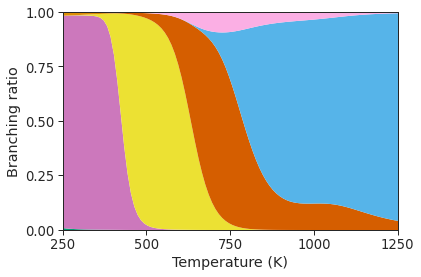

In [29]:
f, ax = plt.subplots()
((df_1d.T/df_1d.sum(1)).T).plot.area(ax=ax,color=colorblind_custom,linewidth=0)
#(df_1d).plot.area(ax=ax,color=colorblind_custom,linewidth=0)
ax.legend([],frameon=False)
ax.set_ylim(0,1)
ax.set_xlim(250,1250)
ax.set_xticks([250,500,750,1000,1250])
ax.set_yticks([0,.25,.5,.75,1])
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Branching ratio')

In [33]:
f.savefig(os.path.join(overall_image_path,'n_propane_1d.svg'))

## butanol

In [34]:
variables = butanol_vars

In [35]:
variables['cantera_input_file']

'../data/mechanism/gamma_i_butanol.cti'

In [36]:
solution=ctt.create_mechanism(variables['cantera_input_file'])

In [37]:
# 8 cycles
species_to_plot = ['OOCC(CO)C',
                       ['[O]CC(CO)C','galdol'],
                       ['OOCC(C=O)C','OOCC(C(O[O])O)C','O=CC(C)C(OO)O','OOCC(CO)CO[O]','OCC(O[O])(COO)C','O=CC(CO)COO','OCC(OO)(C=O)C'],
                       ['galdoxy','O=CC(C)C=O'],'galkene',
                       ['CC=C','propene3ol','OCC=C'], 'NO2OCC(CO)C',
                       ['disub_c4ether','disub_epoxy','monosub_c4ether'],
                      ]
in_legend = ['HO2 pathway', 'NO alkoxy pathway','KHP Cycle','water loss','HO2 + alkene', 
                'R decomp','NO nitrate pathway','cyclic ether + OH']
# get expected products
expected_products = []
for item in species_to_plot:
    if isinstance(item,list):
        for item2 in item:
            expected_products.append(item2)
    else:
        expected_products.append(item)


In [38]:
temperatures = np.linspace(250,1250,100)
pressures=[0.5e5]
NO=[1e-9]
other_conditions = {'HO2_frac': 1e-11}

In [39]:
df_3d = simulate_branching_various_conditions_3D(solution,temperatures = temperatures,
                                                               pressures = pressures,
                                                               NO_fracs = NO,
                                                               expected_products = expected_products,
                                                 conversion_species=variables['conversion_species'],
                                                 starting_alkyl_radical=variables['starting_alkyl_radical'],
                                                               **other_conditions)

In [40]:
df_1d = pd.DataFrame(index=df_3d['temp (K)'])

In [41]:
for index, rxn_name in enumerate(in_legend):
    tgt_species = species_to_plot[index]
    if isinstance(tgt_species,str):
        tgt_species = [tgt_species]
    df_1d[rxn_name] = df_3d[tgt_species].sum(1).values

In [42]:
colorblind_custom_butanol= [colorblind_custom[x] for x in [0, 1, 2, 7, 3, 4,5,6, 8,]]

Text(0, 0.5, 'Branching ratio')

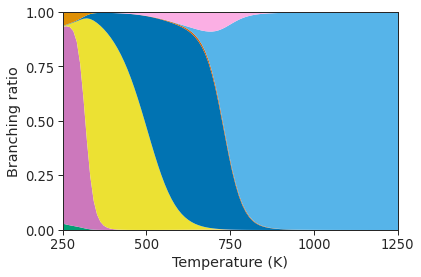

In [43]:
f, ax = plt.subplots()
((df_1d.T/df_1d.sum(1)).T).plot.area(ax=ax,color=colorblind_custom_butanol,linewidth=0)
#df_1d.plot.area(ax=ax,color=colorblind_custom_butanol,linewidth=0)

ax.legend([],frameon=False)
ax.set_ylim(0,1)
ax.set_xlim(250,1250)
ax.set_xticks([250,500,750,1000,1250])
ax.set_yticks([0,.25,.5,.75,1])
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Branching ratio')

In [44]:
f.savefig(os.path.join(overall_image_path,'butanol_1d_w_HO2_elimination.svg'))